<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Ellipses-with-Shapely" data-toc-modified-id="Ellipses-with-Shapely-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Ellipses with Shapely</a></span></li><li><span><a href="#by-tile_id" data-toc-modified-id="by-tile_id-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>by tile_id</a></span></li><li><span><a href="#by-obsid" data-toc-modified-id="by-obsid-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>by obsid</a></span></li><li><span><a href="#Shapely-checks" data-toc-modified-id="Shapely-checks-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Shapely checks</a></span></li></ul></div>

# Read fans and blotches (Do always)

In [1]:
import sys

if sys.platform == 'darwin':
    rootpath = Path("/Users/klay6683/Dropbox/data/planet4/p4_for_Zade/P4_catalog_v1.1/")
else:
    rootpath = Path("C:/Users/Zade/Documents/python_from_others/planet4_results/")
                    
fans = pd.read_csv(rootpath / "P4_catalog_v1.1_L1C_cut_0.5_fan.csv")
blotches = pd.read_csv(rootpath / "P4_catalog_v1.1_L1C_cut_0.5_blotch.csv")

# Ellipses with Shapely 

In [ ]:
from planet4.markings import Fan, Blotch

In [ ]:
from planet4 import markings

In [ ]:
d = dict(x=1, y=2, radius_1=3, radius_2=2, angle=35)
blotch = markings.Blotch(pd.Series(d))

In [ ]:
%matplotlib inline

In [ ]:
from planet4 import io, plotting
obsid = 'ESP_011544_0985'
id_ = 'bdb'
pm = io.PathManager(obsid=obsid, datapath='p4_analysis/p4_catalog')

In [ ]:
pm.obsid_final_blotches_path

In [ ]:
from planet4.catalog_production import ReleaseManager

In [ ]:
rm = ReleaseManager('v1.0')

In [ ]:
df = rm.read_blotch_file()

In [ ]:
df = pd.read_csv(pm.obsid_final_blotches_path)

# by tile_id

In [ ]:
fans = pd.read_csv(r"C:\Users\Zade\Documents\python_from_others\P4_catalog_v1.1_L1C_cut_0.5_fan.csv")

blotches = pd.read_csv(r"C:\Users\Zade\Documents\python_from_others\P4_catalog_v1.1_L1C_cut_0.5_blotch.csv")

In [ ]:
id_ = 'bdb'

In [ ]:
from planet4 import io

In [ ]:
blotches = blotches[blotches.tile_id == io.check_and_pad_id(id_)]

In [ ]:
fans = fans[fans.tile_id == io.check_and_pad_id(id_)]

In [ ]:
import geopandas as gp

In [ ]:
import shapely

In [ ]:
gs_blotch = gp.GeoSeries([markings.Blotch(row).to_shapely() for _,row in blotches.iterrows()])

gs_fans = gp.GeoSeries([markings.Fan(row).to_shapely() for _,row in fans.iterrows()])

In [ ]:
gs = pd.concat([gs_blotch, gs_fans], ignore_index=True, sort=True)

In [ ]:
gs.head()

In [ ]:
id_ = 'bdb'
p4id = markings.TileID(id_)

In [ ]:
%matplotlib ipympl

In [ ]:
p4id.plot_fans(data=fans)
ax =plt.gca()
p4id.plot_blotches(data=blotches, ax=ax)

In [ ]:
gs.plot()
ax = plt.gca()
ax.set_xlim((0, markings.IMG_X_SIZE))
ax.set_ylim((0, markings.IMG_Y_SIZE))
ax.invert_yaxis()

In [ ]:
gs.head()

In [ ]:
from shapely.ops import unary_union

In [ ]:
unionized = gs.unary_union

In [ ]:
x, y = markings.calc_fig_size(8)

In [ ]:
import seaborn as sns
sns.set_context('talk')

In [ ]:
squared_pixel_scale = fans.map_scale.iloc[0]**2
squared_pixel_scale

In [ ]:
fans.map_scale.iloc[0]

In [ ]:
unionized.area

In [ ]:
unionized

In [ ]:
area = unionized.area * squared_pixel_scale
area

In [ ]:
pixel_area = markings.IMG_X_SIZE * markings.IMG_Y_SIZE
tile_area = pixel_area * squared_pixel_scale
tile_area

In [ ]:
fraction = area / tile_area
fraction

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(1.8*x, y), constrained_layout=True)
p4id.plot_fans(data=fans, ax=ax[0])
p4id.plot_blotches(data=blotches, ax=ax[0])
# p4id.show_subframe(ax=ax[1])
gp.GeoSeries(unionized).boundary.plot(ax=ax[1])
ax[1].set_xlim(-25, markings.IMG_X_SIZE+25)
ax[1].set_ylim(markings.IMG_Y_SIZE+25, -25)

ax[1].set_axis_off()
fig.suptitle(id_)
ax[0].set_title('Combined fans and blotches')
ax[1].set_title(f"""Union out of shapely fans and blotches.
Area: {area:.0f} $m^2$; Fraction: {fraction*100:.0f} %""")
fig.savefig('shapely_both.png', dpi=100)

In [ ]:
poly = unionized[0]

In [ ]:
poly.boundary.xy[0][0]

In [ ]:
df1 = gp.GeoDataFrame({'geometry': gs})
df1.head()

In [ ]:
unionized

In [ ]:
inters = gp.overlay(df1, df1, how='intersection')
inters.plot()

# by obsid

In [ ]:
fans.columns

In [ ]:
fans.l_s.value_counts()

In [ ]:
obsid = 'ESP_012643_0945'
obsid = 'ESP_013049_0950'
# obsid = 'ESP_011447_0950'

In [ ]:
fans[fans.obsid.map(lambda x: x.endswith("_0950"))].obsid.value_counts()

In [ ]:
fans_obsid = fans.query("obsid == @obsid")
blotches_obsid = blotches.query("obsid == @obsid")

In [ ]:
fans_obsid.l_s.value_counts()

In [ ]:
fans_obsid.tile_id.nunique()

In [ ]:
gs_blotch = gp.GeoSeries([markings.Blotch(row, scope='hirise').to_shapely() for _,row in blotches_obsid.iterrows()])

gs_fans = gp.GeoSeries([markings.Fan(row, scope='hirise').to_shapely() for _,row in fans_obsid.iterrows()])

In [ ]:
gs = pd.concat([gs_blotch, gs_fans], ignore_index=True, sort=True)

In [ ]:
gs.shape

In [ ]:
unioned = gs.unary_union

In [ ]:
fans_obsid.map_scale.value_counts()

# Shapely checks

In [ ]:
import pandas as pd

In [ ]:
fans = pd.read_csv(r"C:\Users\Zade\Documents\python_from_others\P4_catalog_v1.1_L1C_cut_0.5_fan.csv")

blotches = pd.read_csv(r"C:\Users\Zade\Documents\python_from_others\P4_catalog_v1.1_L1C_cut_0.5_blotch.csv")

In [ ]:
fan1 = markings.Fan(pd.Series({'x':100.000001, 'y':200.000001, 'angle':0,'spread':10,'distance':100}))

In [ ]:
#look at code, create a fan with the same base point but rotated off.  Make sure that so long as base points
#are the same but rotated (eg 180 degrees) it's valid.  I think it will be so long as only one point touches.
#create fans, mess with floating points and rotating the fans, see if base points with floating points, different angles work.
#see if unary unions work for rotated fans.  Don't use geoseries, just use shapelys normal unary unions

In [ ]:
fan2 = markings.Fan(pd.Series({'x':100.000001, 'y':200.000001, 'angle':180,'spread':10,'distance':100}))

In [ ]:
fan1_shape = fan1.to_shapely()
fan2_shape = fan2.to_shapely()

In [ ]:
fan1_shape

In [ ]:
fan2_shape

In [ ]:
newfan = fan1_shape.union(fan2_shape)

In [ ]:
newfan

In [ ]:
newfan.is_valid

In [ ]:
fan3 = markings.Fan(pd.Series({'x':100.000002, 'y':200.000002, 'angle':180,'spread':10,'distance':100}))

In [ ]:
fan3_shape = fan3.to_shapely()

In [ ]:
otherfan = fan3_shape.union(fan2_shape)

In [ ]:
otherfan

In [ ]:
otherfan.is_valid #this being valid shows that even with an almost complete intersection, unionizing them makes them valid. 

In [ ]:
#perhaps unary unions are different
unionized

In [ ]:
unionized.is_valid #this shows that the unionized object we have for our one tile is valid and should not throw our error.

In [ ]:
#continuing obsid checks:
fans.columns

In [ ]:
#obsid = 'ESP_012643_0945'
obsid = 'ESP_013049_0950'
# obsid = 'ESP_011447_0950'

In [ ]:
fans[fans.obsid.map(lambda x: x.endswith("_0950"))].obsid.value_counts()

In [ ]:
fans_obsid = fans.query("obsid == @obsid")
blotches_obsid = blotches.query("obsid == @obsid")

In [ ]:
fans_obsid.l_s.value_counts()

In [ ]:
fans_obsid.tile_id.nunique()

In [ ]:
gs_blotch = gp.GeoSeries([markings.Blotch(row, scope='hirise').to_shapely() for _,row in blotches_obsid.iterrows()])

gs_fans = gp.GeoSeries([markings.Fan(row, scope='hirise').to_shapely() for _,row in fans_obsid.iterrows()])

In [ ]:
gs = pd.concat([gs_blotch, gs_fans], ignore_index=True, sort=True)


In [ ]:
gs.shape


In [ ]:
unioned = gs.unary_union 
#error in GEOS, unresolved : https://github.com/Toblerity/Shapely/issues/47


In [ ]:
gs.is_valid.count() == gs.count()#every individual object is also valid

# New Function

In [4]:
import pandas as pd
from planet4 import io
import geopandas as gp
import numpy as np
import shapely
from planet4 import markings
from shapely.ops import unary_union
from shapely.geometry import Polygon

In [5]:
fans = pd.read_csv(r"C:\Users\Zade\Documents\python_from_others\planet4_results\P4_catalog_v1.1_L1C_cut_0.5_fan.csv")

blotches = pd.read_csv(r"C:\Users\Zade\Documents\python_from_others\planet4_results\P4_catalog_v1.1_L1C_cut_0.5_blotch.csv")

In [6]:
#new function that creates a polygon out of fans/blotches, break up get_tile_fraction into one that finds fraction,
#as well as one that creates polygons for fans, blotches, and mixed.
#make get tile fraction call that function
#make getobsid to call the polygon function

#run loop through every tile on its own,dont use counters, can look at dictionary stuff too! 
#then try to get obsid % coverage

In [21]:
bucket = []
for tile_id in all_tiles:
    d = {}
    d['tile_id'] = tile_id
    d['result'] = get_tile_fraction(tile_id)
    bucket.append(d)

TopologyException: Input geom 1 is invalid: Self-intersection at or near point 1203.604953161705 54706.912139640168 at 1203.604953161705 54706.912139640168


ValueError: No Shapely geometry can be created from null value

In [7]:
def get_polygon(tile_id, scope = 'hirise', mix = 'Mixed'):
    id_ = tile_id
    blotch = blotches[blotches.tile_id == io.check_and_pad_id(id_)]
    fan = fans[fans.tile_id == io.check_and_pad_id(id_)]
    gs_blotch = gp.GeoSeries([markings.Blotch(row, scope).to_shapely() for _,row in blotch.iterrows()])
    gs_fans = gp.GeoSeries([markings.Fan(row, scope).to_shapely() for _,row in fan.iterrows()])
    if mix == 'Mixed':
        gs = pd.concat([gs_blotch, gs_fans], ignore_index=True, sort=True)
        unionized = gs.unary_union
        return unionized
    if mix == 'Blotch':
        unionized_b = gs_blotch.unary_union
        return unionized_b
    if mix == 'Fans':
        unionized_f = gs_fans.unary_union
        return unionized_f
    else:
        return "Please enter Mix, Blotch, or Fans for 'mix' value"

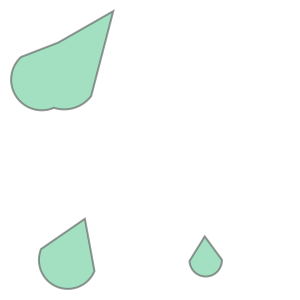

In [10]:
get_polygon('bdb', mix = 'Fans')

In [20]:
def get_tile_fraction(tile_id, scope = 'hirise', mix = 'Mixed'):
    id_ = tile_id
    blotch = blotches[blotches.tile_id == io.check_and_pad_id(id_)]
    fan = fans[fans.tile_id == io.check_and_pad_id(id_)]
    gs_blotch = gp.GeoSeries([markings.Blotch(row, scope).to_shapely() for _,row in blotch.iterrows()])
    gs_fans = gp.GeoSeries([markings.Fan(row, scope).to_shapely() for _,row in fan.iterrows()])
    squared_pixel_scale = fans.map_scale.iloc[0]**2
    pixel_area = markings.IMG_X_SIZE * markings.IMG_Y_SIZE
    if mix == 'Mixed':
        gs = pd.concat([gs_blotch, gs_fans], ignore_index=True, sort=True)
        unionized = gs.unary_union
        area = unionized.area * squared_pixel_scale
        tile_area = pixel_area * squared_pixel_scale
        fraction = area / tile_area
        return fraction
    if mix == 'Blotch':
        unionized_b = gs_blotch.unary_union
        area_b = unionized_b.area * squared_pixel_scale
        tile_area_b = pixel_area * squared_pixel_scale
        fraction_b = area_b / tile_area_b
        return fraction_b
    if mix == 'Fans':
        unionized_f = gs_fans.unary_union
        area_f = unionized_f.area * squared_pixel_scale
        tile_area_f = pixel_area * squared_pixel_scale
        fraction_f = area_f / tile_area_f
        return fraction_f
    else:
        return "Please enter Mix, Blotch, or Fans for 'mix' value"
    

In [ ]:
get_tile_fraction('bdb', mix = 'Blotch') +get_tile_fraction('bdb', mix = 'Fans') 

In [ ]:
get_tile_fraction('bdb', mix = 'Blotch')

In [ ]:
get_tile_fraction('bdb', mix = 'Fans')

In [ ]:
get_tile_fraction('bdb')

In [ ]:
#fan obsid values, unique
f_o_v = np.unique(fans.obsid.values)

In [11]:
obsid_test = 'ESP_012079_0945'

In [12]:
obsid_test

'ESP_012079_0945'

In [13]:
fans_obsid = fans.query('obsid == @obsid_test').tile_id.unique()

In [14]:
blotch_obsid = blotches.query('obsid == @obsid_test').tile_id.unique()

In [15]:
mixed_obsid = np.concatenate((fans_obsid, blotch_obsid))

In [16]:
all_tiles = np.unique((mixed_obsid))

In [ ]:
len(all_tiles)

In [ ]:
#just loop over all tiles in all_tiles with my get_tile_fraction function
for i in len(all_tiles):
    get_tile_fraction(i)

In [ ]:
tile_id = all_tiles[0]

In [ ]:
#the check and pad id fits the first bit of the tile id in front of the last few digits, doesn't matter for us when we collect
#full legal IDs as he showed above.
for tile_id in all_tiles:
    test_blotches = blotches.query('tile_id == @tile_id')

In [ ]:
test_blotches

In [ ]:
test_blotches = blotches.query('tile_id == @tile_id')
test_blotches

In [ ]:
def get_obsid_fraction(the_obsid, scope = 'hirise'): #add fans vs blotches vs mixed later
    test_array = []
    squared_pixel_scale = fans.map_scale.iloc[0]**2
    pixel_area = markings.IMG_X_SIZE * markings.IMG_Y_SIZE
    if np.any(fans.obsid.values[:]) == the_obsid or np.any(blotches.obsid.values[:]) == the_obsid:
        test_array.append(fans.tile_id)
        test_array.append(blotches.tile_id)
    
    
    
    #return test_array #shows test array is working, but when I make unique get new error.
    u_test_array = np.unique(test_array, return_index = False)
    #u_test_array = u_test_array.reset_index(drop=True)
    #return u_test_array
    
    poly = Polygon() #creates an empty polygon to union with
    for tile_id in test_array:
        blotch = blotches[blotches.tile_id == tile_id]
        gs_blotch = gp.GeoSeries([markings.Blotch(row, scope).to_shapely() for _, row in blotch.iterrows])
        gs_fans = gp.GeoSeries([markings.Fan(row, scope).to_shapely() for _,row in fan.iterrows()])
        gs = pd.concat([gs_blotch, gs_fans], ignore_index=True, sort=True)
        unionized = gs.unary_union
        x = unionized.union(poly)
        #add x to poly 'catch the result' 
        
    area = poly.area * squared_pixel_scale
    tile_area = pixel_area * squared_pixel_scale #need obsid area, not tile area- how to do this?
    fraction = area / tile_area
    return fraction

In [ ]:
get_obsid_fraction(obsid_test)

In [ ]:
get_obsid_fraction(obsid_test)